## Capstone Project : Building a Comprehensive Job Recommendation System

## Srimanth Madira - Data Science (M.S) - U01885136

## Import Statements

In [306]:
import pandas as pd
import numpy as np
import re

## Data Load

In [307]:
#Loading Data Using Pandas Library
data = pd.read_csv("dice_com-job_us_sample.csv")

In [308]:
data.head()

,advertiserurl,company,employmenttype_jobstatus,jobdescription,jobid,joblocation_address,jobtitle,postdate,shift,site_name,skills,uniq_id
0,https://www.dice.com/jobs/detail/AUTOMATION-TE...,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,Dice Id : 10110693,"Atlanta, GA",AUTOMATION TEST ENGINEER,1 hour ago,Telecommuting not available|Travel not required,NaN,SEE BELOW,418ff92580b270ef4e7c14f0ddfc36b4
1,https://www.dice.com/jobs/detail/Information-S...,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,Dice Id : 10114469,"Chicago, IL",Information Security Engineer,1 week ago,Telecommuting not available|Travel not required,NaN,"linux/unix, network monitoring, incident respo...",8aec88cba08d53da65ab99cf20f6f9d9
2,https://www.dice.com/jobs/detail/Business-Solu...,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...",Dice Id : CXGALXYS,"Schaumburg, IL",Business Solutions Architect,2 weeks ago,Telecommuting not available|Travel not required,NaN,"Enterprise Solutions Architecture, business in...",46baa1f69ac07779274bcd90b85d9a72
3,https://www.dice.com/jobs/detail/Java-Develope...,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,Dice Id : 10113627,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",2 weeks ago,Telecommuting not available|Travel not required,NaN,Please see job description,3941b2f206ae0f900c4fba4ac0b18719
4,https://www.dice.com/jobs/detail/DevOps-Engine...,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Dice Id : matrixga,"Atlanta, GA",DevOps Engineer,48 minutes ago,Telecommuting not available|Travel not required,NaN,"Configuration Management, Developer, Linux, Ma...",45efa1f6bc65acc32bbbb953a1ed13b7


## Data Cleaning, Standardization

In [309]:
data_info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   advertiserurl             22000 non-null  object
 1   company                   21950 non-null  object
 2   employmenttype_jobstatus  21770 non-null  object
 3   jobdescription            22000 non-null  object
 4   jobid                     22000 non-null  object
 5   joblocation_address       21997 non-null  object
 6   jobtitle                  22000 non-null  object
 7   postdate                  22000 non-null  object
 8   shift                     21643 non-null  object
 9   site_name                 3490 non-null   object
 10  skills                    21957 non-null  object
 11  uniq_id                   22000 non-null  object
dtypes: object(12)
memory usage: 2.0+ MB


In [310]:
#Checking for the Missing Values
data.isnull().sum()

advertiserurl                   0
company                        50
employmenttype_jobstatus      230
jobdescription                  0
jobid                           0
joblocation_address             3
jobtitle                        0
postdate                        0
shift                         357
site_name                   18510
skills                         43
uniq_id                         0
dtype: int64

In [311]:
#Dropping Unnecessary Columns
data_cleaned = data.drop(columns=['advertiserurl', 'jobid', 'postdate', 'site_name', 'uniq_id'])

data_cleaned.columns

Index(['company', 'employmenttype_jobstatus', 'jobdescription',
       'joblocation_address', 'jobtitle', 'shift', 'skills'],
      dtype='object')

In [312]:
data_cleaned.isnull().sum()

company                      50
employmenttype_jobstatus    230
jobdescription                0
joblocation_address           3
jobtitle                      0
shift                       357
skills                       43
dtype: int64

In [313]:
columns_to_impute = ['company', 'employmenttype_jobstatus', 'joblocation_address', 'shift']

for column in columns_to_impute:
    mode_value = data_cleaned[column].mode()[0]  
    data_cleaned[column].fillna(mode_value, inplace=True)  

In [315]:
#Finding the number of unique Skills present over the entire dataset
skills_data = data_cleaned['skills'].dropna()

all_skills = skills_data.str.split(',|\s+').apply(lambda x: [skill.strip() for skill in x if skill.strip() != ''])

flattened_skills = [skill for sublist in all_skills for skill in sublist]

unique_skills = list(set(flattened_skills))

print("Unique skills found in the 'skills' column:")
print(len(unique_skills))

Unique skills found in the 'skills' column:
21168


In [317]:
#Code to remove unnecessary braces and parenthesis from the rows of skills
import re

def clean_skill(skill):
    cleaned_skill = re.sub(r'[\(\)\[\]\{\}]', '', skill) 
    cleaned_skill = re.sub(r'\bAND\b', '', cleaned_skill, flags=re.IGNORECASE) 
    return cleaned_skill.strip()  

cleaned_skills = [clean_skill(skill) for skill in unique_skills]

In [318]:
#Function to extract the skills from the job description, where skills are missing
def extract_skills_from_description(description):
    found_skills = [skill for skill in cleaned_skills if re.search(r'\b' + re.escape(skill) + r'\b', description, re.IGNORECASE)]
    return ', '.join(found_skills) if found_skills else None

for index, row in data_cleaned[data_cleaned['skills'].isnull()].iterrows():
    extracted_skills = extract_skills_from_description(row['jobdescription'])
    if extracted_skills:
        data_cleaned.at[index, 'skills'] = extracted_skills  

print("Missing values in 'skills' after extraction:")
print(data_cleaned['skills'].isnull().sum())

Missing values in 'skills' after extraction:
0


In [276]:
data_cleaned[data_cleaned['skills'].isnull() == False].head(286)

,company,employmenttype_jobstatus,jobdescription,joblocation_address,jobtitle,shift,skills
0,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,"Atlanta, GA",AUTOMATION TEST ENGINEER,Telecommuting not available|Travel not required,SEE BELOW
1,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,"Chicago, IL",Information Security Engineer,Telecommuting not available|Travel not required,"linux/unix, network monitoring, incident respo..."
2,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...","Schaumburg, IL",Business Solutions Architect,Telecommuting not available|Travel not required,"Enterprise Solutions Architecture, business in..."
3,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",Telecommuting not available|Travel not required,Please see job description
4,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,"Atlanta, GA",DevOps Engineer,Telecommuting not available|Travel not required,"Configuration Management, Developer, Linux, Ma..."
...,...,...,...,...,...,...,...
281,The Armada Group,"Contract Independent, 3+ mon CTH","As a Full Stack Software Engineer, you will co...","San Jose, CA",Full stack Software Engineer,Telecommuting not available|Travel not required,Skills and Experience required * Full-stack en...
282,"TAD PGS, Inc","Contract W2, 6 Months","TAD PGS, INC. is currently seeking a Software ...","Huntsville, AL",Software Specialist VI,Telecommuting not available|Travel not required,"TAD PGS, INC. specializes in delivering secure..."
283,TM Floyd,BASED ON EXPERIENCE,Server Analyst Responsibilities: Perform serve...,"Columbia, SC",Server Analyst,Telecommuting not available|Travel not required,"work, may, IMPLEMENT, Including, maintenance, ..."
284,Mitchell Martin,"Full Time, Full Time",Our client is seeking a Splunk Admin. Locati...,"Lake Success, NY",Splunk Admin,Telecommuting not available|Travel not required,"Capacity Planning, Configuration Management, C..."


In [319]:
description_rows = data_cleaned['skills'].str.contains(r'\bdescription\b', case=False, na=False)

num_description_rows = description_rows.sum()

print(f"Number of rows where 'skills' contains the word 'description': {num_description_rows}")

Number of rows where 'skills' contains the word 'description': 213


In [320]:
keywords = ['description', 'BELOW']

pattern = r'\b(?:' + '|'.join(keywords) + r')\b'

description_rows = data_cleaned['skills'].str.contains(pattern, case=False, na=False)

num_description_rows = description_rows.sum()

print(f"Number of rows where 'skills' contains the specified keywords: {num_description_rows}")


Number of rows where 'skills' contains the specified keywords: 244


In [321]:
#Function to extract the skills from the description where ever skills are mentioned as see description below
description_rows = data_cleaned['skills'].str.contains(r'\b(?:description|below)\b', case=False, na=False)
data_cleaned.loc[description_rows, 'skills'] = ''

def extract_unique_skills(description):
    found_skills = [skill for skill in cleaned_skills if re.search(r'\b' + re.escape(skill) + r'\b', description, re.IGNORECASE)]
    return ', '.join(found_skills) if found_skills else ''  

for index, row in data_cleaned[description_rows].iterrows():
    extracted_skills = extract_unique_skills(row['jobdescription'])
    data_cleaned.at[index, 'skills'] = extracted_skills 

In [322]:
data_cleaned[['jobdescription', 'skills']].head(10)

,jobdescription,skills
0,Looking for Selenium engineers...must have sol...,"work, DESIGN, GO, testing, Engineering, desire..."
1,The University of Chicago has a rapidly growin...,"linux/unix, network monitoring, incident respo..."
2,"GalaxE.SolutionsEvery day, our solutions affec...","Enterprise Solutions Architecture, business in..."
3,Java DeveloperFull-time/direct-hireBolingbrook...,"work, middle, DESIGN, C, Type, tier, throughou..."
4,Midtown based high tech firm has an immediate ...,"Configuration Management, Developer, Linux, Ma..."
5,We are looking for a Senior SAP FICO Architect...,"FICO, AR, AP, Asset Management, HAHA"
6,Network Engineer Job Description A Network Eng...,"Cisco, DNS, HTTP, Networking, Network Engineer..."
7,Bluebeam is looking for talented sr. web devel...,".NET , C#, MVC, RESTful web services, HTTP, AW..."
8,This is a fulltime position for a Javascript d...,"C++, Developer, Development, JavaScript, User ..."
9,SummaryOur client is the leading provider of o...,"work, code, may, testing, troubleshooting, fil..."


In [20]:
description_rows = data_cleaned['skills'].str.contains(r'\bdescription\b', case=False, na=False)

data_cleaned.loc[description_rows, 'skills'] = None

def extract_unique_skills(description):
    found_skills = set(skill for skill in cleaned_skills if re.search(r'\b' + re.escape(skill) + r'\b', description, re.IGNORECASE))
    return ', '.join(found_skills) if found_skills else None

for index, row in data_cleaned[description_rows].iterrows():
    extracted_skills = extract_unique_skills(row['jobdescription'])
    if extracted_skills:
        data_cleaned.at[index, 'skills'] = extracted_skills  

In [138]:
data_cleaned[description_rows][['jobdescription', 'skills']].head(5)

,jobdescription,skills
0,Looking for Selenium engineers...must have sol...,"[work, DESIGN, GO, testing, Engineering, ..."
3,Java DeveloperFull-time/direct-hireBolingbrook...,"[work, middle, DESIGN, C, Type, tier, th..."
9,SummaryOur client is the leading provider of o...,"[work, code, may, testing, troubleshooting..."
15,Windows Systems Administrator The Windows Syst...,"[work, DESIGN, citrix, testing, Engineerin..."
19,Our client in the healthcare software industry...,"[middle, DESIGN, tier, IT, Including, thr..."


In [323]:
data_cleaned.isnull().sum()

company                     0
employmenttype_jobstatus    0
jobdescription              0
joblocation_address         0
jobtitle                    0
shift                       0
skills                      0
dtype: int64

In [324]:
data_cleaned.head(5)

,company,employmenttype_jobstatus,jobdescription,joblocation_address,jobtitle,shift,skills
0,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,"Atlanta, GA",AUTOMATION TEST ENGINEER,Telecommuting not available|Travel not required,"work, DESIGN, GO, testing, Engineering, desire..."
1,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,"Chicago, IL",Information Security Engineer,Telecommuting not available|Travel not required,"linux/unix, network monitoring, incident respo..."
2,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...","Schaumburg, IL",Business Solutions Architect,Telecommuting not available|Travel not required,"Enterprise Solutions Architecture, business in..."
3,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",Telecommuting not available|Travel not required,"work, middle, DESIGN, C, Type, tier, throughou..."
4,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,"Atlanta, GA",DevOps Engineer,Telecommuting not available|Travel not required,"Configuration Management, Developer, Linux, Ma..."


In [325]:
#Splitting the address by delimeter and storing them in separate field as city, state
if data_cleaned['joblocation_address'].str.contains(',').any():
    split_address = data_cleaned['joblocation_address'].str.split(',', n=1, expand=True)
    data_cleaned['city'] = split_address[0].str.strip() 
    data_cleaned['state'] = split_address[1].str.strip() 

data_cleaned[['joblocation_address', 'city', 'state']].head()

,joblocation_address,city,state
0,"Atlanta, GA",Atlanta,GA
1,"Chicago, IL",Chicago,IL
2,"Schaumburg, IL",Schaumburg,IL
3,"Bolingbrook, IL",Bolingbrook,IL
4,"Atlanta, GA",Atlanta,GA


In [326]:
count = 0
if not data_cleaned['joblocation_address'].str.contains(',').any():
    count = count + 1
    data_cleaned['city'] = None  # Set city to None
    data_cleaned['state'] = None  # Set state to None

data_cleaned[['joblocation_address', 'city', 'state']].head()

0


In [327]:
no_comma_mask = ~data_cleaned['joblocation_address'].str.contains(',')

data_cleaned.loc[no_comma_mask, 'city'] = None
data_cleaned.loc[no_comma_mask, 'state'] = None

print(data_cleaned[['joblocation_address', 'city', 'state']].head(7496))

     joblocation_address         city state
0            Atlanta, GA      Atlanta    GA
1            Chicago, IL      Chicago    IL
2         Schaumburg, IL   Schaumburg    IL
3        Bolingbrook, IL  Bolingbrook    IL
4            Atlanta, GA      Atlanta    GA
...                  ...          ...   ...
7491         Atlanta, GA      Atlanta    GA
7492       Baltimore, MD    Baltimore    MD
7493          Laurel, MD       Laurel    MD
7494                  Va         None  None
7495         Atlanta, GA      Atlanta    GA

[7496 rows x 3 columns]


In [328]:
no_comma_mask = ~data_cleaned['joblocation_address'].str.contains(',')

data_cleaned.loc[no_comma_mask, 'city'] = None
data_cleaned.loc[no_comma_mask, 'state'] = None


for index in data_cleaned[no_comma_mask].index:
    address = data_cleaned.at[index, 'joblocation_address'].strip() 
    
    if len(address) == 2:
        data_cleaned.at[index, 'state'] = address  
    elif len(address) > 2:
        data_cleaned.at[index, 'city'] = address  

In [329]:
data_cleaned.head()

,company,employmenttype_jobstatus,jobdescription,joblocation_address,jobtitle,shift,skills,city,state
0,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,"Atlanta, GA",AUTOMATION TEST ENGINEER,Telecommuting not available|Travel not required,"work, DESIGN, GO, testing, Engineering, desire...",Atlanta,GA
1,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,"Chicago, IL",Information Security Engineer,Telecommuting not available|Travel not required,"linux/unix, network monitoring, incident respo...",Chicago,IL
2,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...","Schaumburg, IL",Business Solutions Architect,Telecommuting not available|Travel not required,"Enterprise Solutions Architecture, business in...",Schaumburg,IL
3,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",Telecommuting not available|Travel not required,"work, middle, DESIGN, C, Type, tier, throughou...",Bolingbrook,IL
4,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,"Atlanta, GA",DevOps Engineer,Telecommuting not available|Travel not required,"Configuration Management, Developer, Linux, Ma...",Atlanta,GA


In [330]:
data_cleaned = data_cleaned.drop(columns=['joblocation_address'])

cols = ['company', 'employmenttype_jobstatus', 'jobdescription', 'city', 'state', 'jobtitle', 'shift', 'skills']
data_cleaned = data_cleaned[cols]

In [331]:
data_cleaned.head()

,company,employmenttype_jobstatus,jobdescription,city,state,jobtitle,shift,skills
0,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,Atlanta,GA,AUTOMATION TEST ENGINEER,Telecommuting not available|Travel not required,"work, DESIGN, GO, testing, Engineering, desire..."
1,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,Chicago,IL,Information Security Engineer,Telecommuting not available|Travel not required,"linux/unix, network monitoring, incident respo..."
2,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...",Schaumburg,IL,Business Solutions Architect,Telecommuting not available|Travel not required,"Enterprise Solutions Architecture, business in..."
3,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,Bolingbrook,IL,"Java Developer (mid level)- FT- GREAT culture,...",Telecommuting not available|Travel not required,"work, middle, DESIGN, C, Type, tier, throughou..."
4,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Atlanta,GA,DevOps Engineer,Telecommuting not available|Travel not required,"Configuration Management, Developer, Linux, Ma..."


In [332]:
import pandas as pd

# Filter rows where 'city' is missing
missing_city_rows = data_cleaned[data_cleaned['city'].isna()]

# Get unique states where 'city' is missing
unique_states = missing_city_rows['state'].unique()

# Display the names of the states
print("States where City is missing:")
print(unique_states)


States where City is missing:
['Co' 'Ca' 'Va' 'Dc' 'De' 'Md' 'Ny']


In [333]:
states_with_missing_city = ['Co', 'Ca', 'Va', 'Dc', 'De', 'Md', 'Ny']

state_city_mapping = {
    'Co': 'Denver',
    'Ca': 'Los Angeles',
    'Va': 'Richmond',
    'Dc': 'Washington',
    'De': 'Dover',
    'Md': 'Baltimore',
    'Ny': 'New York'
}

def fill_missing_city(row):
    if row['city'] is None and row['state'] in state_city_mapping:
        return state_city_mapping[row['state']]
    return row['city']

data_cleaned['city'] = data_cleaned.apply(fill_missing_city, axis=1)

In [334]:
missing_state_rows = data_cleaned[data_cleaned['state'].isnull()]

common_cities = missing_state_rows['city'].dropna().unique()


print(common_cities)

['Sacramento' 'Santa Clara' 'United States' 'Mexico City' 'Any City'
 'Bangkok' 'Hyderabad' 'Bangalore' 'Brentwood' 'Peterborough' 'Sunnyvale'
 'Phila' 'Toronto' 'Cherry Hill' 'Delhi' 'San Francisco' 'Beijing'
 'Reading' 'Pune' 'San Isidro' 'St Petersburg' 'Mumbai' 'Konstanz'
 'Chandigarh' 'Central' 'Guantanamo Bay' 'Guantanamo']


In [335]:
# Identify unique city names where state is missing
unique_missing_state_cities = data_cleaned[data_cleaned['state'].isna()]['city'].unique()

# Convert to a list for easier display
unique_missing_state_cities_list = unique_missing_state_cities.tolist()

# Print the unique city names
print(unique_missing_state_cities_list)


['Sacramento', 'Santa Clara', 'United States', 'Mexico City', 'Any City', 'Bangkok', 'Hyderabad', 'Bangalore', 'Brentwood', 'Peterborough', 'Sunnyvale', 'Phila', 'Toronto', 'Cherry Hill', 'Delhi', 'San Francisco', 'Beijing', 'Reading', 'Pune', 'San Isidro', 'St Petersburg', 'Mumbai', 'Konstanz', 'Chandigarh', 'Central', 'Guantanamo Bay', 'Guantanamo']


In [336]:
city_state_mapping = {
    'Sacramento': 'CA',
    'Santa Clara': 'CA',
    'United States': 'US',
    'Mexico City': 'MX',
    'Any City': "City",  
    'Bangkok': 'TH',
    'Hyderabad': 'IN',
    'Bangalore': 'IN',
    'Brentwood': 'CA',
    'Peterborough': 'ON',  
    'Sunnyvale': 'CA',
    'Phila': 'PA',
    'Toronto': 'ON', 
    'Cherry Hill': 'NJ',
    'Delhi': 'DL',  
    'San Francisco': 'CA',
    'Beijing': 'BJ',  
    'Reading': 'PA',
    'Pune': 'IN',
    'San Isidro': 'CA',
    'St Petersburg': 'FL',
    'Mumbai': 'MH',  # India
    'Konstanz': 'BW',  # Germany
    'Chandigarh': 'CH',  # India
    'Central': 'City',  # Assuming you don't want to assign a state
    'Guantanamo Bay': 'CU',  # Cuba
    'Guantanamo': 'CU'  # Cuba
}

# Function to fill missing states based on city
def fill_missing_state(row):
    if pd.isna(row['state']) and row['city'] in city_state_mapping:
        return city_state_mapping[row['city']]
    return row['state']

# Apply the function to update the DataFrame
data_cleaned['state'] = data_cleaned.apply(fill_missing_state, axis=1)

In [337]:
data_cleaned.isnull().sum()

company                     0
employmenttype_jobstatus    0
jobdescription              0
city                        0
state                       0
jobtitle                    0
shift                       0
skills                      0
dtype: int64

## Exploratory Data Analysis

In [338]:
state_job_counts = data_cleaned['state'].value_counts()

top_5_states = state_job_counts.head(5)

print(top_5_states)

state
CA    4623
NY    2213
GA    1925
TX    1924
NJ    1820
Name: count, dtype: int64


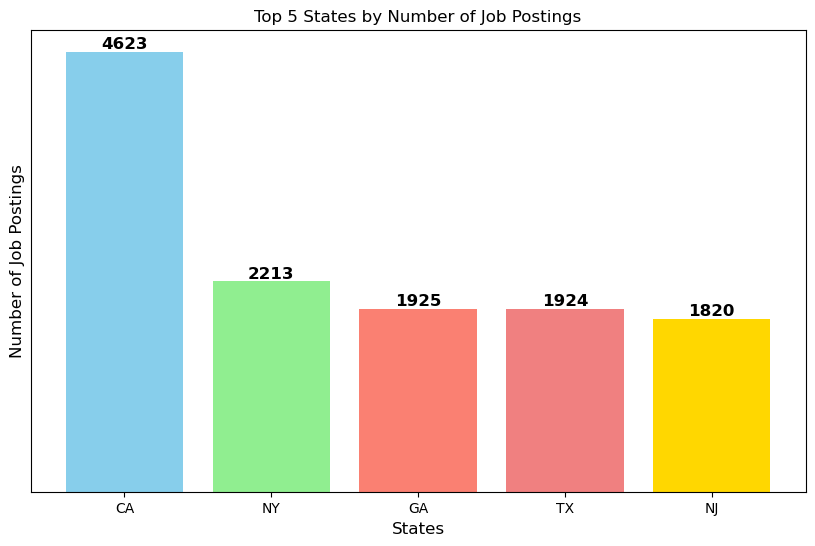

In [339]:
import matplotlib.pyplot as plt

top_states = data_cleaned['state'].value_counts().nlargest(5)

colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'gold']
plt.figure(figsize=(10,6))
bars = plt.bar(top_states.index, top_states.values, color=colors)

plt.xlabel('States', fontsize=12)
plt.ylabel('Number of Job Postings', fontsize=12)
plt.title('Top 5 States by Number of Job Postings', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.yticks([])

plt.show()


In [340]:
city_job_counts = data_cleaned['city'].value_counts()

top_7_cities = city_job_counts.head(7)

print(top_7_cities)

city
New York         1373
Atlanta          1245
San Francisco     889
Seattle           661
Boston            608
Houston           536
San Jose          452
Name: count, dtype: int64


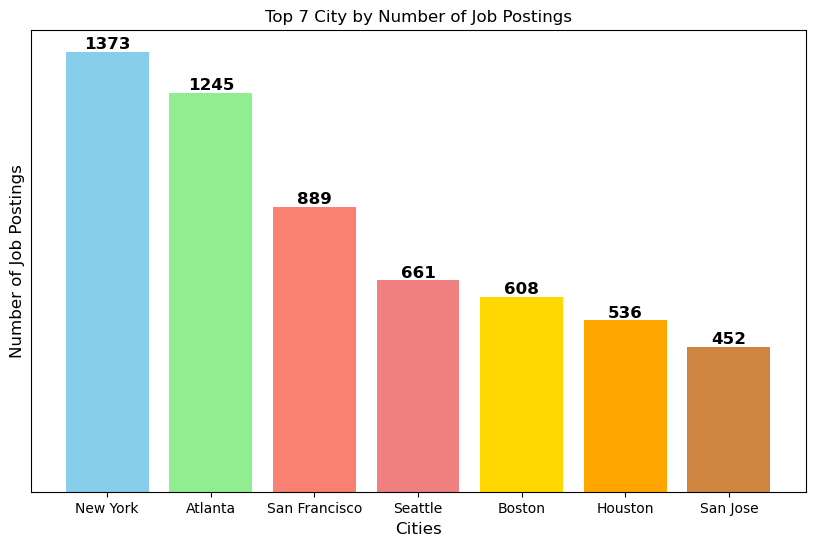

In [341]:
import matplotlib.pyplot as plt

top_cities = data_cleaned['city'].value_counts().nlargest(7)

colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'gold', 'orange', 'peru']
plt.figure(figsize=(10,6))
bars = plt.bar(top_cities.index, top_cities.values, color=colors)

plt.xlabel('Cities', fontsize=12)
plt.ylabel('Number of Job Postings', fontsize=12)
plt.title('Top 7 City by Number of Job Postings', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.yticks([])

plt.show()

In [351]:
# Create a new column to store the length of each job description (in terms of number of words)
data_cleaned['jobdescription_length'] = data_cleaned['jobdescription'].apply(lambda x: len(str(x).split()))

# Display the first few rows to verify
data_cleaned[['jobtitle', 'jobdescription', 'jobdescription_length']].head()


,jobtitle,jobdescription,jobdescription_length
0,AUTOMATION TEST ENGINEER,Looking for Selenium engineers...must have sol...,528
1,Information Security Engineer,The University of Chicago has a rapidly growin...,285
2,Business Solutions Architect,"GalaxE.SolutionsEvery day, our solutions affec...",389
3,"Java Developer (mid level)- FT- GREAT culture,...",Java DeveloperFull-time/direct-hireBolingbrook...,351
4,DevOps Engineer,Midtown based high tech firm has an immediate ...,141


In [354]:
# Group by job title and calculate the average job description length
avg_desc_length_by_job = data_cleaned.groupby('jobtitle')['jobdescription_length'].mean().reset_index()

# Sort the values by average length (descending) to see which job titles have the longest descriptions
avg_desc_length_by_job = avg_desc_length_by_job.sort_values(by='jobdescription_length', ascending=False)

# Display the top 10 job titles with the longest job descriptions
print(avg_desc_length_by_job.head(20))


                                                jobtitle  \
14334          Transportation Security Inspector - Cargo   
9659                     SAP CRM Functional Analyst Lead   
2978   Deputy Chief Information Officer/Chief Informa...   
8198                    PMO Quality Assurance Consultant   
1910                 CIS Assistant Director of Education   
2163                 Clinical Informatics Analyst (Epic)   
1917                     CLOUD & INFRASTRUCTURE ENGINEER   
8492                          Portfolio Services Analyst   
4882            IES Senior Business Operations Specalist   
485                        Account Manager - Req ID:1622   
7693            OCM Mergers & Acquisitions (M&A) Manager   
14685  Vice President, Corporate Integrity & Internal...   
3819                 Enterprise Data Warehouse Architect   
10291  Sales Force Effectiveness Digital Sales Effect...   
403                                AVP, Business Systems   
3970                  F5 Traffic Managem

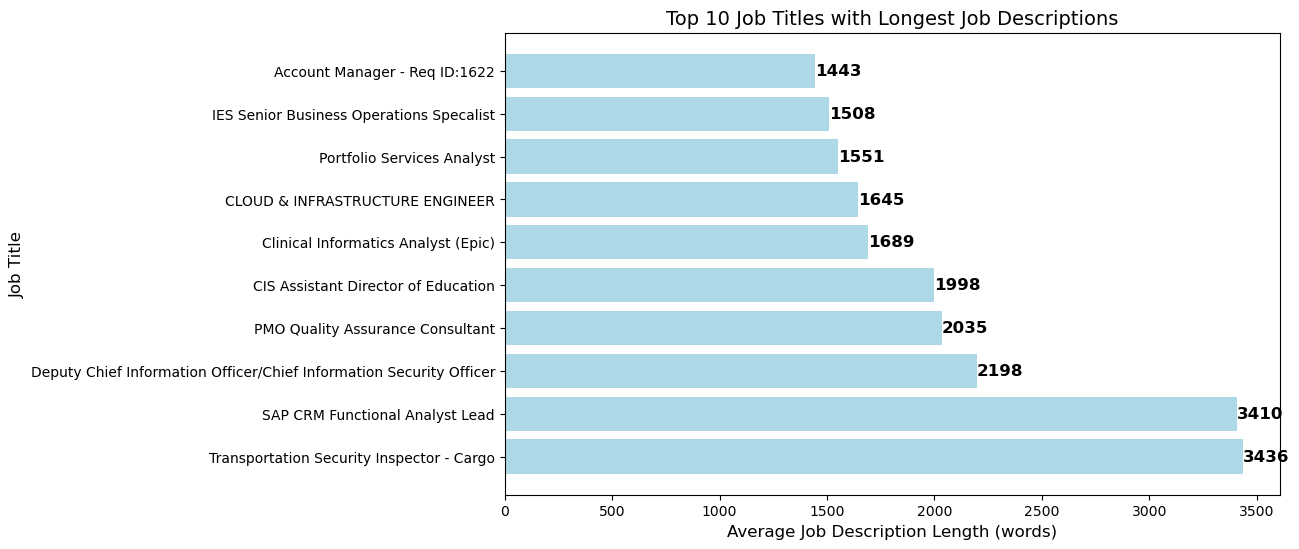

In [355]:
import matplotlib.pyplot as plt

# Plotting the top 10 job titles with the longest average job description length
top_10_jobs = avg_desc_length_by_job.head(10)

plt.figure(figsize=(10,6))
bars = plt.barh(top_10_jobs['jobtitle'], top_10_jobs['jobdescription_length'], color='lightblue')

plt.xlabel('Average Job Description Length (words)', fontsize=12)
plt.ylabel('Job Title', fontsize=12)
plt.title('Top 10 Job Titles with Longest Job Descriptions', fontsize=14)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}', 
             va='center', fontsize=12, fontweight='bold')

plt.show()


In [348]:
# Group by city, state, and job title to find the frequency of each combination
grouped_data = data_cleaned.groupby(['city', 'state', 'jobtitle']).size().reset_index(name='count')

# Display the top combinations
grouped_data.sort_values(by='count', ascending=False).head(20)


,city,state,jobtitle,count
1074,Atlanta,GA,Java Developer,13
11203,New York,NY,Software Development Engineer,11
1480,Atlanta,GA,Senior Java Developer,10
10967,New York,NY,Project Manager,10
810,Atlanta,GA,Business Analyst,9
10382,New York,NY,Business Analyst,9
10747,New York,NY,Java Developer,9
17277,Seattle,WA,Software Development Engineer,8
803,Atlanta,GA,Backbase Developer,8
11212,New York,NY,Software Engineer,8


In [343]:
# Count the total number of jobs
total_jobs = len(data_cleaned)

# Count the number of Full Time jobs
full_time_jobs = data_cleaned['employmenttype_jobstatus'].str.contains('Full Time', case=False, na=False).sum()

# Calculate the number of non-Full Time jobs
non_full_time_jobs = total_jobs - full_time_jobs

# Calculate the percentages
full_time_percentage = (full_time_jobs / total_jobs) * 100
non_full_time_percentage = (non_full_time_jobs / total_jobs) * 100

# Display the results
print(f"Percentage of Full Time jobs: {full_time_percentage:.2f}%")
print(f"Percentage of Non-Full Time jobs: {non_full_time_percentage:.2f}%")


Percentage of Full Time jobs: 57.75%
Percentage of Non-Full Time jobs: 42.25%


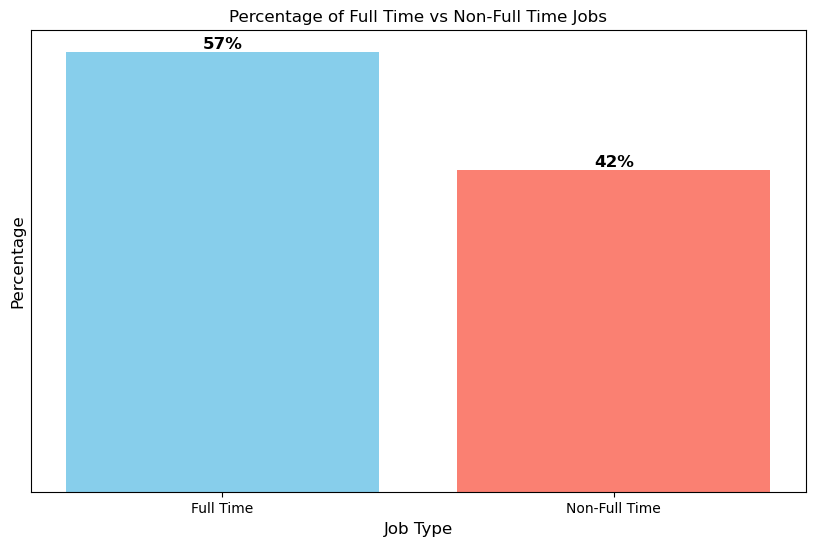

In [344]:
job_types = ['Full Time', 'Non-Full Time']
percentages = [full_time_percentage, non_full_time_percentage]

# Colors for the bars
colors = ['skyblue', 'salmon']

# Create the bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(job_types, percentages, color=colors)

# Set labels and title
plt.xlabel('Job Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Percentage of Full Time vs Non-Full Time Jobs', fontsize=12)

# Display percentages on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove the y-axis ticks for a cleaner look
plt.yticks([])

# Show the plot
plt.show()

In [1]:
import pandas as pd
from collections import Counter

data_cleaned['skills'] = data_cleaned['skills'].str.split(',')

all_skills = data_cleaned['skills'].explode().str.strip()  

skill_counts = Counter(all_skills)

skills_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count'])

top_10_skills = skills_df.nlargest(10, 'Count')

top_10_skills.head()

NameError: name 'data_cleaned' is not defined

In [233]:
data_cleaned.to_csv('cleaned_skills_data.csv', index=False)

In [305]:
data_cleaned.head()

,company,employmenttype_jobstatus,jobdescription,city,state,jobtitle,shift,skills
0,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,Atlanta,GA,AUTOMATION TEST ENGINEER,Telecommuting not available|Travel not required,NaN
1,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,Chicago,IL,Information Security Engineer,Telecommuting not available|Travel not required,NaN
2,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...",Schaumburg,IL,Business Solutions Architect,Telecommuting not available|Travel not required,NaN
3,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,Bolingbrook,IL,"Java Developer (mid level)- FT- GREAT culture,...",Telecommuting not available|Travel not required,NaN
4,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Atlanta,GA,DevOps Engineer,Telecommuting not available|Travel not required,NaN
